In [9]:
# ============================================================
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats
# Charger votre dataset
data = pd.read_excel(r'C:\Users\stude\OneDrive\Bureau\these_version_ultime\data_complet(reg).xlsx')

# Créer la nouvelle colonne binaire
data['Antécédants familiaux_histoire modérée'] = 0

# La colonne prend la valeur 1 seulement quand les deux colonnes précédentes sont à 0
data.loc[(data['Antécédants familiaux_amsterdam II'] == 0) & 
       (data['Antécédants familiaux_pas d\'histoire'] == 0), 
       'Antécédants familiaux_histoire modérée'] = 1

data.drop(columns= 'Antécédants familiaux_amsterdam II', inplace=True)
data.head()

# Créer une variable simplifiée avec une seule modalité pour les multiples
data['type_tumeur_simplifie'] = 'autre_tumeur'

# Dès qu'un cancer multiple est détecté → catégorie "multiples"
data.loc[data['cancer multiples'] == 1, 'type_tumeur_simplifie'] = 'multiples'

# Pour les tumeurs uniques, on précise le type
data.loc[(data['cancer multiples'] == 0) & (data['tumeur colorectal'] == 1), 'type_tumeur_simplifie'] = 'colon_seul'
data.loc[(data['cancer multiples'] == 0) & (data['tumeur endometrial'] == 1), 'type_tumeur_simplifie'] = 'endo_seul'


# Supprimer les colonnes inutiles
data = data.drop(columns=['tumeur endometrial', 'tumeur colorectal', 'cancer multiples'])

# Encodage one-hot
data_encoded = pd.get_dummies(data, columns=['type_tumeur_simplifie'], drop_first=True)

# Conversion des colonnes en float
for col in data_encoded.columns:
    data_encoded[col] = data_encoded[col].astype(float)


# ============================================================
# 2. DÉFINITION DES VARIABLES X ET Y
# ============================================================
X = data_encoded.drop(columns=["muté/methylé"])
y = data_encoded["muté/methylé"]

# ============================================================
# 3. RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION (L1, L2 OU ELASTICNET)
# ============================================================
# Choisir le type de régularisation : 'l1', 'l2' ou 'elasticnet'
penalty_type = 'l1'   # ⬅️ change ici si besoin
C_value = 1.6         # Plus petit C = plus de régularisation

# Créer un pipeline avec standardisation + régression logistique
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty=penalty_type,
        solver='saga',   # obligatoire pour L1 ou ElasticNet
        C=C_value,
        class_weight='balanced',
        max_iter=10000
    ))
])

# Entraîner le modèle
model.fit(X, y)

# ============================================================
# 4. CALCUL DES COEFFICIENTS, P-VALUES ET INTERVALLES DE CONFIANCE
# ============================================================
# Récupérer les coefficients et intercept
coefficients = model.named_steps['logreg'].coef_[0]
intercept = model.named_steps['logreg'].intercept_[0]

# Calcul des probabilités prédites
p_pred = model.predict_proba(X)[:, 1]

# Calcul de la matrice d'information de Fisher pour approximer la variance
X_design = np.hstack([np.ones((X.shape[0], 1)), StandardScaler().fit_transform(X)])  # ajouter constante
V = np.diag(p_pred * (1 - p_pred))
cov_matrix = np.linalg.inv(X_design.T @ V @ X_design)

# Erreurs standards
standard_errors = np.sqrt(np.diag(cov_matrix))

# Valeurs z
z_scores = np.array([intercept] + list(coefficients)) / standard_errors

# P-values bilatérales
p_values = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))

# Intervalle de confiance à 95 %
conf_int_lower = np.array([intercept] + list(coefficients)) - 1.96 * standard_errors
conf_int_upper = np.array([intercept] + list(coefficients)) + 1.96 * standard_errors

# ============================================================
# 5. AFFICHAGE DES RÉSULTATS
# ============================================================
feature_names = ['constante'] + list(X.columns)
results_df = pd.DataFrame({
    "Variables": feature_names,
    "Coefficient": np.round([intercept] + list(coefficients), 4),
    "Std_Error": np.round(standard_errors, 4),
    "z_score": np.round(z_scores, 4),
    "p_value": np.round(p_values, 6),
    "CI_95_lower": np.round(conf_int_lower, 4),
    "CI_95_upper": np.round(conf_int_upper, 4)
})

print("\n=== RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION ===")
print(results_df)

# ============================================================
# 6. ÉVALUATION RAPIDE
# ============================================================
from sklearn.metrics import classification_report, roc_auc_score

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y, model.predict(X)))

print("AUC :", roc_auc_score(y, p_pred))

data['type_tumeur_simplifie'].value_counts()


=== RÉGRESSION LOGISTIQUE AVEC RÉGULARISATION ===
                                Variables  Coefficient  Std_Error  z_score  \
0                               constante       0.1179     0.2633   0.4479   
1               age de la premiere tumeur      -0.2860     0.2811  -1.0176   
2    Antécédants familiaux_pas d'histoire       1.3317     0.3189   4.1765   
3                           IHC MMR_M1/P2       0.1613     0.3990   0.4042   
4                              IHC MMR_P2      -0.1645     0.4102  -0.4010   
5  Antécédants familiaux_histoire modérée      -0.0740     0.3086  -0.2398   
6        type_tumeur_simplifie_colon_seul       0.2579     0.6164   0.4183   
7         type_tumeur_simplifie_endo_seul       0.3263     0.4399   0.7418   
8         type_tumeur_simplifie_multiples       0.4815     0.6008   0.8015   

    p_value  CI_95_lower  CI_95_upper  
0  0.654220      -0.3981       0.6340  
1  0.308870      -0.8369       0.2649  
2  0.000030       0.7068       1.9567  
3  0.686

type_tumeur_simplifie
colon_seul      52
multiples       28
endo_seul       10
autre_tumeur     5
Name: count, dtype: int64

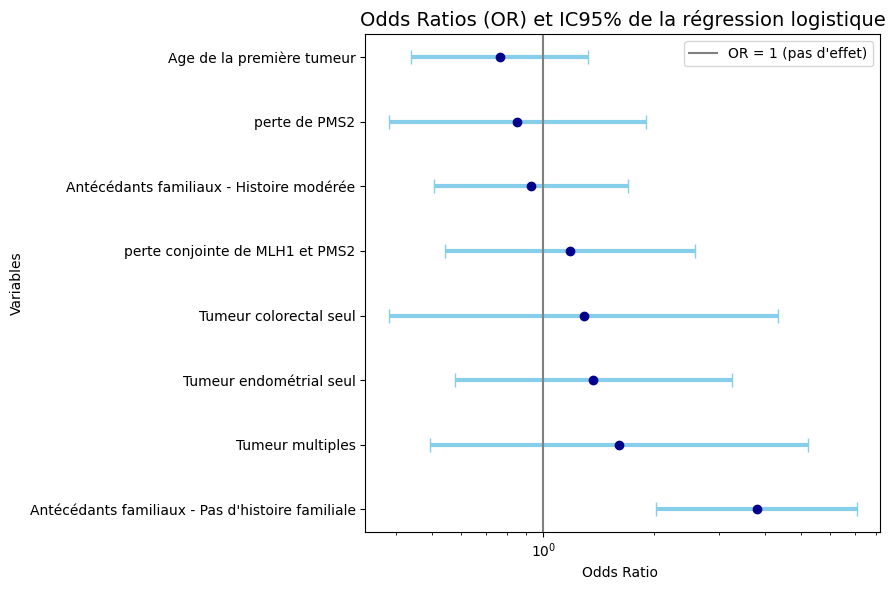

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Tes résultats sous forme de DataFrame ===
df = pd.DataFrame({
    "Variable": [
        "Age de la première tumeur",
        "Antécédants familiaux - Pas d'histoire familiale",
        "Antécédants familiaux - Histoire modérée",
        "perte conjointe de MLH1 et PMS2",
        "perte de PMS2",
        "Tumeur colorectal seul",
        "Tumeur endométrial seul",
        "Tumeur multiples"
    ],
    "Coefficient": [-0.2718, 1.3317, -0.0740, 0.1665, -0.1631, 0.2525, 0.3130, 0.4736],
    "CI_lower": [-0.8230, 0.7068, -0.6788, -0.6157, -0.9649, -0.9609, -0.5499, -0.7088],
    "CI_upper": [0.2795, 1.9567, 0.5308, 0.9488, 0.6387, 1.4659, 1.1759, 1.6560]
})

# === Calcul des Odds Ratios ===
df["OR"] = np.exp(df["Coefficient"])
df["OR_lower"] = np.exp(df["CI_lower"])
df["OR_upper"] = np.exp(df["CI_upper"])

# Trier les variables par impact
df = df.sort_values("OR", ascending=False)

# === Création du graphique ===
plt.figure(figsize=(9,6))
plt.errorbar(df["OR"], df["Variable"], 
             xerr=[df["OR"] - df["OR_lower"], df["OR_upper"] - df["OR"]],
             fmt='o', color='darkblue', ecolor='skyblue', elinewidth=3, capsize=5)

# Ligne de référence OR=1
plt.axvline(x=1, color='grey', linestyle='-', label="OR = 1 (pas d'effet)")

# Titres et labels
plt.title("Odds Ratios (OR) et IC95% de la régression logistique", fontsize=14)
plt.xlabel("Odds Ratio ")
plt.ylabel("Variables")
plt.xscale("log")
plt.legend()
plt.tight_layout()
plt.show()
